# A flexible and precise approximation to the Wang (2002) NMDA Model
Jan-Eirik Welle Skaar and Hans Ekkehard Plesser, Spring 2024

This notebook briefly describes the approximation underlying the `iaf_bw_2001` model in NEST. The model itself was first published in

Wang, X.-J. (2002). Probabilistic Decision Making by Slow Reverberation in Cortical Circuits. Neuron, 36(5), 955–968. https://doi.org/10.1016/S0896-6273(02)01092-9

## Synaptic currents of the Wang (2002) model

The synaptic input currents of the model are defined as follows (Wang 2002, p 966):
$$\begin{align}
    I_\mathrm{syn}(t) &= 
    I_\mathrm{rec, AMPA}(t) 
    + I_\mathrm{rec, NMDA}(t) 
    + I_\mathrm{rec, GABA}(t) \mathrm{,}\\[1.5ex]
    I_\mathrm{ext,AMPA} &= g_\mathrm{ext,AMPA}\times (V(t) - V_E) \times S_{j,\mathrm{ext, AMPA}}(t)\mathrm{,}\\
    I_\mathrm{rec,AMPA} &= g_\mathrm{rec,AMPA}\times (V(t) - V_E) \times \sum_{j=1}^{N_E}w_jS_{j,\mathrm{rec,AMPA}}(t) \mathrm{,}\\
    I_\mathrm{rec,NMDA} &= \frac{g_\mathrm{rec,NMDA}\times (V(t) - V_E)}{1+[\mathrm{Mg^{2+}}]\mathrm{exp}(-0.062V(t))/3.57}\times \sum_{j=1}^{N_E}w_jS_{j,\mathrm{NMDA}}(t) \mathrm{,}\\
    I_\mathrm{rec,GABA} &= g_\mathrm{rec,GABA}\times(V(t) - V_I) \times\sum_{j=1}^{N_E}w_jS_{j,\mathrm{GABA}}(t) \;\mathrm{.}
\end{align}
$$

Note that in contrast to common practice, $I_\mathrm{syn}\sim g (V-V_\text{rev})$ is defined with positive sign and then entered into the membrane potential equation with negative sign as $\dot{V} \sim \dots - I_\mathrm{syn}$. For consistency with the model definition, the NEST implementation follows this convention.

The synaptic activations $S_{j,\mathrm{ext,AMPA}},S_{j,\mathrm{rec,AMPA}},S_{j,\mathrm{NMDA}},\ \mathrm{ and }\ S_{j,\mathrm{GABA}}$
are governed by the equations

$$\begin{align} 
    \frac{dS_{j,\mathrm{AMPA}}}{dt} &= -\frac{S_{j,\mathrm{AMPA}}}{\tau_\mathrm{AMPA}}+\sum_k \delta (t - t_j^k) \\
    \frac{dS_{j,\mathrm{GABA}}}{dt} &= -\frac{S_{j,\mathrm{GABA}}}{\tau_\mathrm{GABA}} + \sum_k \delta (t - t_j^k) \\
    \frac{dS_{j,\mathrm{NMDA}}}{dt} &= -\frac{S_{j,\mathrm{NMDA}}}{\tau_\mathrm{NMDA,decay}}+ \alpha x_j (1 - S_{j,\mathrm{NMDA}}) \\
    \frac{dx_j}{dt} &= - \frac{x_j}{\tau_\mathrm{NMDA,rise}} + \sum_k \delta (t - t_j^k) \;\mathrm{,}
\end{align}
$$
where indices $j$ mark presynaptic neurons and $k$ spike times.

This original model by Wang (2002) is implemented in NEST as `iaf_bw_2001_exact`. Due to the nonlinear term $x_j (1 - S_{j,\mathrm{NMDA}})$, NMDA synapses cannot be combined together, so each incoming synapse to a neuron needs to be integrated individually, significantly impacting performance. Note that $S_{j,\mathrm{NMDA}}(t)$ represents the input to a given neuron from presynaptic neuron $j$. Importantly, the same $S_j(t)$ describes input to all neurons postsynaptic to $j$, although shifted by possibly different delays and weighted by different input weights. This allows us to compute $S_j(t)$ only once in neuron $j$ and then distribute this value, for each simulation time step, to all post-synaptic neurons of $j$.

Prior implementations of the model, such as the [Brian2 implementation by Wimmer and Stimberg](https://brian2.readthedocs.io/en/stable/examples/frompapers.Wang_2002.html) and presumably Wang's original implementation, circumvent address this by investigating a model with all-to-all connectivity with a single delay value and fixed-timestep forward Euler integration. The NEST implementation supports arbitrary connectivity and delays, and uses RKF45 adaptive stepsize integration. 

## Approximation of NMDA dynamics

We will from now on only focus on the last two equations, which are the subjects of the approximation in the model. We drop the subscript NMDA in the following and abbreviate "rise" and "decay" as "r" and "d", respectively. 

Assume that neuron $j$ last spiked at time zero and does not spike again until $t$. Then we obtain the following expression for time evolution of $S_j$ until $t$ by plugging in the solution for $x_j$ on the interval $(0, t]$:
$$
\begin{align}
    \frac{dS_{j}}{dt} + \bigg(\frac{1}{\tau_\mathrm{d}} + \alpha x_j^0 \mathrm{exp}\bigg[-\frac{t}{\tau_\mathrm{r}}\bigg] \bigg) S_{j,\mathrm{NMDA}} &= \alpha x_j^0 \mathrm{exp}\bigg[-\frac{t}{\tau_\mathrm{r}}\bigg] \;\mathrm{.}
\end{align}
$$
We obtain the formal solution by an integrating factor as
$$
    S_{j}(t)  = \mathrm{exp}\Bigg[-\int_0^t \frac{1}{\tau_\mathrm{d}} + \alpha x_j^0 \mathrm{exp}\bigg[-\frac{t'}{\tau_\mathrm{r}} \bigg] dt' \Bigg] 
    \Bigg( S_{j}^0 +\int_0^t \mathrm{exp}\Bigg[\int_0^{t'} \frac{1}{\tau_\mathrm{d}} + \alpha x_j^0 \mathrm{exp}\bigg[-\frac{t''}{\tau_\mathrm{r}} \bigg] dt'' \Bigg]\alpha x_j^0 \mathrm{exp}\bigg[-\frac{t'}{\tau_\mathrm{r}}\bigg] dt'  \Bigg) \mathrm{,}
$$

with $S_j^0=S_j(t=0)$. The first and innermost integrals can be solved in closed form, which gives
$$
    S_{j}(t) 
    = 
    \mathrm{exp}\Bigg[-\frac{t}{\tau_\mathrm{d}} - \alpha x_j^{0} \tau_\mathrm{r} \bigg( 1-\mathrm{exp}\bigg[-\frac{t}{\tau_\mathrm{r}} \bigg] \bigg) \Bigg]
    \Bigg(S_{j}^0+ \alpha x_j^0 \int_0^{t} \mathrm{exp}\Bigg[\bigg( \frac{1}{\tau_\mathrm{d}} - \frac{1}{\tau_\mathrm{r}} \bigg)t' + \alpha x_j^0 \tau_\mathrm{r} \bigg( 1 - \mathrm{exp}\bigg[-\frac{t'}{\tau_\mathrm{r}} \bigg] \bigg) \Bigg] dt'  \Bigg) \mathrm{.}
$$

Since we have two different time scales in the exponential inside the remaining integral, there is no exact solution for arbitrary limits of integration. We would like to approximate this function with an exponential function, such that we can integrate the sum of multiple such functions in a single variable, as we do for the AMPA and GABA synapses.

For NMDA synapses we have $\tau_\mathrm{r}\ll\tau_\mathrm{d}$, whence we define our approximate function between spikes in terms of the decay time constant as
$$
\hat{S_j} (t) = S_\mathrm{post} \mathrm{exp}\Big(-\frac{t}{\tau_d}\Big) \;.
$$
Here $S_\mathrm{post}$ is some initial condition immediately after receiving a spike. We set the value of $S_\mathrm{post}$ such that the approximation is exact in the limit of large $t$, i.e.,
$$
\lim_{t \to \infty} \frac{S_j(t)}{\hat{S}_j(t)}\to 1 \;.
$$
Note that a new $S_\mathrm{post}$ is computed after every spike of neuron $j$.

To obtain $S_\mathrm{post}$, we assume that $x_0 = 0$ immediately before every spike, i.e., that the effect on $x_j$ of the previous spike has vanished by the time the next spike arrives. Since $\tau_r$ is very small (e.g. $2$ ms), this is reasonable unless the neuron is firing very rapidly. Since $x$ is increased by $1$ on every spike, we have $x_0=1$ immediately after spiking. 

We now set our approximation ansatz equal to the exact solution, inserting $x_0=1$, and move the exponential in $\tau_\mathrm{d}$ to the right hand side
$$\begin{align}
    S_\mathrm{post} \mathrm{exp}\Big(-\frac{t}{\tau_d}\Big)
    &=
    \mathrm{exp}\Bigg[-\frac{t}{\tau_\mathrm{d}} - \alpha \tau_\mathrm{r} \bigg( 1-\mathrm{exp}\bigg[-\frac{t}{\tau_\mathrm{r}} \bigg] \bigg) \Bigg]
    \Bigg(S_{j}^0 + \alpha \int_0^{t} \mathrm{exp}\Bigg[(t') \bigg( \frac{1}{\tau_\mathrm{d}} - \frac{1}{\tau_\mathrm{r}} \bigg) + \alpha \tau_\mathrm{r} \bigg( 1 - \mathrm{exp}\bigg[-\frac{t'}{\tau_\mathrm{r}} \bigg] \bigg) \Bigg] dt' \Bigg) \mathrm{,} \\
 \Leftrightarrow   S_\mathrm{post}
    &=
    \mathrm{exp}\Bigg[- \alpha \tau_\mathrm{r} \bigg( 1-\mathrm{exp}\bigg[-\frac{t}{\tau_\mathrm{r}} \bigg] \bigg) \Bigg]
    \Bigg( S_{j}^0 + \alpha \int_0^{t} \mathrm{exp}\Bigg[\bigg( \frac{1}{\tau_\mathrm{d}} - \frac{1}{\tau_\mathrm{r}} \bigg) t' + \alpha \tau_\mathrm{r} \bigg( 1 - \mathrm{exp}\bigg[-\frac{t'}{\tau_\mathrm{r}} \bigg] \bigg) \Bigg]dt'  \Bigg) \;.
\end{align}
$$

Taking the limit $t\to\infty$, the remaining integral becomes

$$
\begin{align}
&\ \int_0^\infty \mathrm{exp}\Bigg[\bigg( \frac{1}{\tau_\mathrm{d}} - \frac{1}{\tau_\mathrm{r}} \bigg) t' + \alpha \tau_\mathrm{r} \bigg( 1 - \mathrm{exp}\bigg[-\frac{t'}{\tau_\mathrm{r}} \bigg] \bigg) \Bigg] dt' \\
&= -\frac{1}{\alpha}\mathrm{exp}[\alpha \tau_r](\alpha \tau_r)^{\frac{\tau_r}{\tau_d}} \int_0^\infty \bigg(\alpha \tau_r \mathrm{exp}\bigg[-\frac{t'}{\tau_\mathrm{r}}\bigg]\bigg)^{-\frac{\tau_r}{\tau_d}} \mathrm{exp}\Bigg[-\alpha \tau_r\mathrm{exp}\bigg[-\frac{t'}{\tau_\mathrm{r}} \bigg] \Bigg] \bigg(-\alpha \mathrm{exp}\bigg[-\frac{t'}{\tau_r}\bigg] \bigg) dt' \\
&= \frac{1}{\alpha}\mathrm{exp}[\alpha \tau_r](\alpha \tau_r)^{\frac{\tau_r}{\tau_d}} \int_0^{\alpha \tau_r} u^{-\frac{\tau_r}{\tau_d}} \mathrm{exp}[-u]du \\
&= \frac{1}{\alpha}\mathrm{exp}[\alpha \tau_r](\alpha \tau_r)^{\frac{\tau_r}{\tau_d}} \gamma \big[1 - \frac{\tau_r}{\tau_d}, \alpha \tau_r \big] \mathrm{,}
\end{align}
$$
where we make the substitution $u = \alpha \tau_r \mathrm{exp}\big[-\frac{t'}{\tau_r} \big]$, and $\gamma$ is the [lower incomplete gamma function](https://en.wikipedia.org/wiki/Incomplete_gamma_function).

We thus have

$$\begin{align}
    S_\mathrm{post} = 
    \mathrm{exp}\Big[-\alpha \tau_\mathrm{r} \Big] S_j^0
    +
    (\alpha \tau_r)^{\frac{\tau_r}{\tau_d}} \gamma \big[1 - \frac{\tau_r}{\tau_d}, \alpha \tau_r \big] \mathrm{,}
\end{align}
$$
where $S_j^0$ is the value of $S_j$ immediately before spiking. Note that since the exact solution $S_j(t)$ includes the full history of $S_j$, and thus $S_\mathrm{post}$ as its approxmation also includes the full history. 

Defining
$$\begin{align}
    k_0 &= (\alpha \tau_r)^{\frac{\tau_r}{\tau_d}} \gamma \big[1 - \frac{\tau_r}{\tau_d}, \alpha \tau_r \big] \\[3ex]
    k'_1 &= \mathrm{exp}(-\alpha \tau_\mathrm{r}) 
\end{align} 
$$
we can write
$$
 S_\mathrm{post} = k_0 + k'_1 S_j^0 \;.
$$

In a presynaptic neuron $j$, let $t_\mathrm{ls}$  be the time of the previous spike and $t^-$ the time immediately before the next spike. Then we have from the definition of our approximation
$$
S_j(t^-) = S_j(t_\mathrm{ls}) \mathrm{exp}\big[-\frac{t^- - t_\mathrm{ls}}{\tau_d}\big] \;.
$$
The value of $S_j$ at $t^+$ immediately after the spike is then given by
$$
S_j(t^+) = S_\mathrm{post} =  k_0 + k'_1 S_j(t^-)
$$
and the change in $S_j$ upon the spike at $t$ is given by
$$
\Delta S_j = S_j(t^+)-S_j(t^-) = k_0 + k'_1 S_j(t^-) - S_j(t^-) = k_0 + k_1 S_j(t^-) \;.
$$
with $k_1 = k'_1 - 1$. The change $\Delta S_j$ is then transmitted to all postsynaptic neurons and added to their aggregated $S$ input variable.


In the exact implementation, the spike only affects $S_j$ through the variable $x_j$, and everything is integrated post-synaptically. After receiving a spike, the variable is updated as
$$
x_j(t^+) = x_j(t^-) + 1
$$
in the post-synaptic neuron, and the value of $S_j$ is updated during the integration of the entire system described in the beginning.

## Comparing exact solution and approximation

### Single neuron

The first case compares a single neuron simulated with the exact and the approximating models.

In [1]:
import nest
import matplotlib.pyplot as plt

import numpy as np


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0-post0.dev0
 Built: Apr 28 2024 17:23:19

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
w_ext = 40.0
w_ex = 1.0
w_in = 15.0

params = {
    "tau_AMPA": 2.0,
    "tau_GABA": 5.0,
    "tau_rise_NMDA": 2.0,
    "tau_decay_NMDA": 100.0,
    "conc_Mg2": 1.0,
    "E_ex": 0.0,
    "E_in": -70.0,
    "E_L": -70.0,
    "V_th": -55.0,
    "C_m": 500.0,
    "g_L": 25.0,
    "V_reset": -70.0,
    "alpha": 0.5,
    "t_ref": 2.0,
}

We create 1 pre-synaptic approximate neuron, 1 post-synaptic approximate and 1 post-synaptic exact neuron. Stimulating the pre-synaptic neuron, we will compare the synaptic variables and membrane potential in the approximate and exact post-synaptic neurons.

In [3]:
nest.ResetKernel()
nest.rng_seed = 12345

# pre-synaptic neuron, must be approximate model since the post-synaptic approximate model needs the offset
nrn_pre = nest.Create("iaf_bw_2001", params)
nrn_post_approx = nest.Create("iaf_bw_2001", params)
nrn_post_exact = nest.Create("iaf_bw_2001_exact", params)

pg = nest.Create("poisson_generator", {"rate": 50.0})

vm_pre = nest.Create("voltmeter", {"interval": nest.resolution})
vm_post_approx = nest.Create("voltmeter", {"interval": nest.resolution})
vm_post_exact = nest.Create("voltmeter", {"interval": nest.resolution})

receptors = nest.GetDefaults("iaf_bw_2001")["receptor_types"]
ampa_ext_syn_spec = {"synapse_model": "static_synapse", "weight": w_ext, "receptor_type": receptors["AMPA"]}

rec_syn_specs = nest.CollocatedSynapses(
    {"synapse_model": "static_synapse", "weight": w_ex, "receptor_type": receptors["AMPA"]},
    {"synapse_model": "static_synapse", "weight": w_ex, "receptor_type": receptors["NMDA"]},
    {"synapse_model": "static_synapse", "weight": w_in, "receptor_type": receptors["GABA"]},
)

nest.Connect(pg, nrn_pre, syn_spec=ampa_ext_syn_spec)
nest.Connect(nrn_pre, nrn_post_approx, syn_spec=rec_syn_specs)
nest.Connect(nrn_pre, nrn_post_exact, syn_spec=rec_syn_specs)

# nest.Connect(nrn_pre, sr)
nest.Connect(vm_pre, nrn_pre)
nest.Connect(vm_post_approx, nrn_post_approx)
nest.Connect(vm_post_exact, nrn_post_exact)

nest.Simulate(1000.0)


Apr 28 21:14:41 NodeManager::add_node [Info]: 
    Neuron models emitting precisely timed spikes exist: the kernel property 
    off_grid_spiking has been set to true.
    
    NOTE: Mixing precise-spiking and normal neuron models may lead to inconsistent results.

Apr 28 21:14:41 NodeManager::add_node [Info]: 
    Neuron models emitting precisely timed spikes exist: the kernel property 
    off_grid_spiking has been set to true.
    
    NOTE: Mixing precise-spiking and normal neuron models may lead to inconsistent results.

Apr 28 21:14:41 NodeManager::prepare_nodes [Info]: 
    Preparing 7 nodes for simulation.

Apr 28 21:14:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 7
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Apr 28 21:14:41 SimulationManager::run [Info]: 
    Simulation finished.


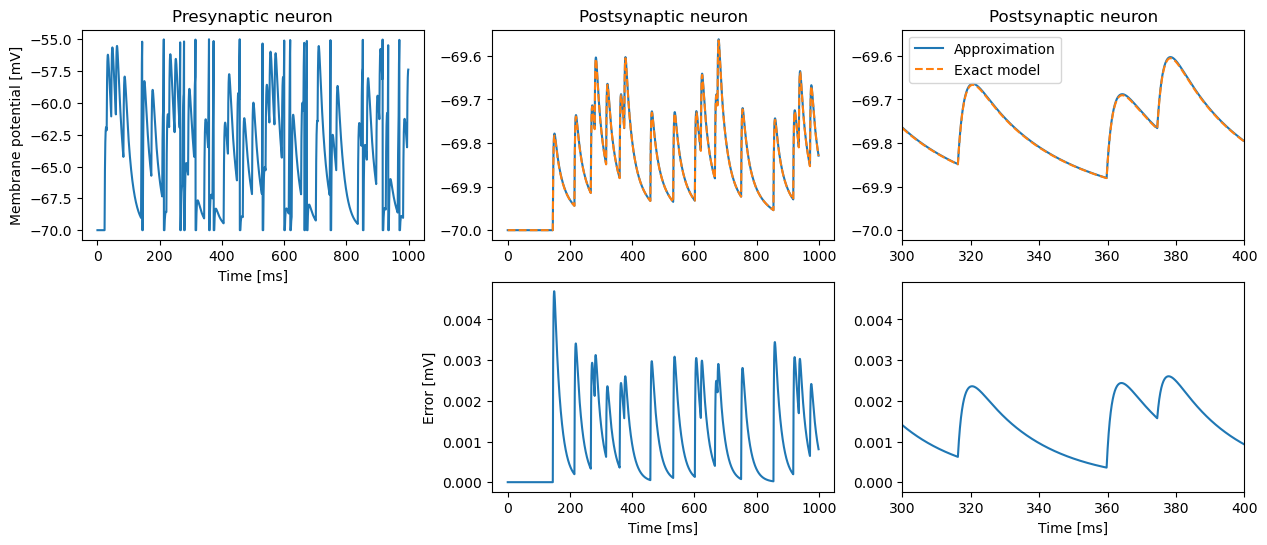

In [4]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches([15, 6])
# fig.subplots_adjust(hspace=0.5, wspace=0.3)

ax[0, 0].plot((ev := vm_pre.events)["times"], ev["V_m"])
ax[0, 0].set_xlabel("Time [ms]")
ax[0, 0].set_ylabel("Membrane potential [mV]")
ax[0, 0].set_title("Presynaptic neuron")

ax[0, 1].plot((ev := vm_post_approx.events)["times"], ev["V_m"], label="Approximation")
ax[0, 1].plot((ev := vm_post_exact.events)["times"], ev["V_m"], "--", label="Exact model")
ax[0, 1].set_title("Postsynaptic neuron")

ax[0, 2].plot((ev := vm_post_approx.events)["times"], ev["V_m"], label="Approximation")
ax[0, 2].plot((ev := vm_post_exact.events)["times"], ev["V_m"], "--", label="Exact model")
ax[0, 2].set_title("Postsynaptic neuron")
ax[0, 2].legend()
ax[0, 2].set_xlim(300, 400)

ax[1, 0].axis("off")

ax[1, 1].plot((ev := vm_post_approx.events)["times"], ev["V_m"] - vm_post_exact.events["V_m"], label="Approximation")
ax[1, 1].set_xlabel("Time [ms]")
ax[1, 1].set_ylabel("Error [mV]")

ax[1, 2].plot((ev := vm_post_approx.events)["times"], ev["V_m"] - vm_post_exact.events["V_m"], label="Approximation")
ax[1, 2].set_xlabel("Time [ms]")
ax[1, 2].set_xlim(300, 400);

### Systematic parameter scan

- In the following, vary
    - number of presynaptic neurons
    - firing rate of the presynaptic neurons
    - weight from pre- to postsynaptic neurons
- Technical aspects
    - drive presynaptic neurons by poisson processes
    - this requires some experimentation with poisson rates to get approximately the desired rates from the presynaptic neuron

In [5]:
def do_sim(n_pre, r_pre, weight, t_sim=1000, show=False, seed=955):
    nest.set_verbosity("M_ERROR")
    nest.ResetKernel()
    nest.rng_seed = seed
    nest.local_num_threads = 4
    sg = nest.Create("poisson_generator", params={"rate": r_pre})

    pp = params.copy()
    pp["t_ref"] = 0
    pre = nest.Create("iaf_bw_2001", n=n_pre, params=pp)  # t_ref==0 to make "parroting" easier
    post_app = nest.Create("iaf_bw_2001", params=params)
    post_exa = nest.Create("iaf_bw_2001_exact", params=params)
    rec_pre, rec_post_app, rec_post_exa = nest.Create("spike_recorder", n=3)
    vm_app, vm_exa = nest.Create("voltmeter", params={"interval": nest.resolution}, n=2)

    nest.Connect(sg, pre, syn_spec={"receptor_type": 1, "weight": 76})  # gives approx one spike out for one in
    nest.Connect(pre, post_app + post_exa, syn_spec={"receptor_type": 3, "weight": weight})
    nest.Connect(pre, rec_pre)
    nest.Connect(post_app, rec_post_app)
    nest.Connect(post_exa, rec_post_exa)
    nest.Connect(vm_app, post_app)
    nest.Connect(vm_exa, post_exa)
    nest.Simulate(t_sim)

    rate_in = rec_pre.n_events / (n_pre * t_sim) * 1000
    rate_post_app = rec_post_app.n_events / t_sim * 1000
    rate_post_exa = rec_post_exa.n_events / t_sim * 1000
    e_app = vm_app.events
    e_exa = vm_exa.events
    rms_Vm = np.mean((e_app["V_m"] - e_exa["V_m"]) ** 2) ** 0.5
    mean_Vm_exa = np.mean(e_exa["V_m"])
    mean_Vm_app = np.mean(e_app["V_m"])

    if show:
        plt.plot(e_app["times"], e_app["V_m"], label="approx")
        plt.plot(e_exa["times"], e_exa["V_m"], label="exact")
        plt.xlabel("Time [ms]")
        plt.ylabel("Membrane potential [mV]")
        plt.legend()

    return {
        "n_pre": n_pre,
        "w": weight,
        "r_pre": r_pre,
        "r_in": rate_in,
        "r_app": rate_post_app,
        "r_exa": rate_post_exa,
        "rms_Vm": rms_Vm,
        "mean_Vm_exa": mean_Vm_exa,
        "mean_Vm_app": mean_Vm_app,
    }

#### Example run to show that we get behavior consistent with first example

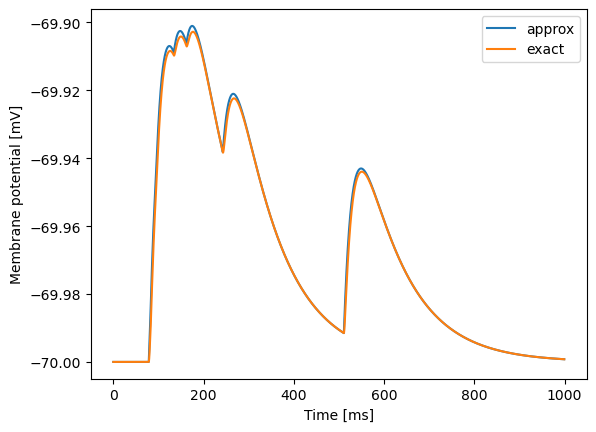

In [6]:
do_sim(1, 10, 1, show=True);

In [7]:
import pandas as pd

In [8]:
n_pre = [1, 10, 100, 1000, 1600, 3200]
weight = [0.1, 1, 10, 20, 50, 100]
r_pre = [4.5, 18, 54, 100]  # chosen so that actual input rates to post neuron are 1, 10, 50, 100

res = []
for npr in n_pre:
    print(f"{npr:6d}", end=":")
    for w in weight:
        for rp in r_pre:
            if npr * rp * w > 1e5:
                continue  # skip unrealistically high input regimes
            print(".", end="")
            res.append(do_sim(npr, rp, w))
        print(":", end="")
    print()

d = pd.DataFrame.from_records(res)
d["Total input"] = d.n_pre * d.r_in * d.w

     1:....:....:....:....:....:....:
    10:....:....:....:....:....:....:
   100:....:....:....:..:..:.:
  1000:....:....:.:.:::
  1600:....:...:.::::
  3200:....:..:::::


### Errors in V_m and s_NMDA 

- Plot against total input, i.e., product of number of presynaptic neurons, input rate and weight
- For Fig 2 in Wang (2002), the total input is 1600 neurons * 25 spikes/neuron/s * 0.165 nS * 1.7 ≈ 11220 nS/s ≈ 10^4
- Color in plots indicates synaptic weight
- Plateau in membrane potential error related to start of spiking regime
- Scale on colorbars is log10(weight)
- Marker size is sqrt(number of presynaptic neurons)

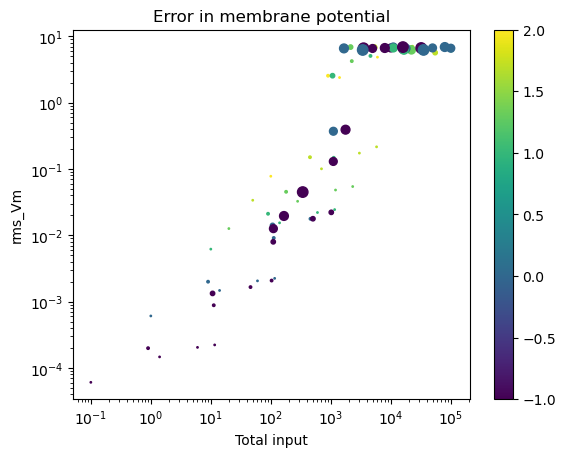

In [9]:
d.plot(
    x="Total input",
    y="rms_Vm",
    kind="scatter",
    c=np.log10(d.w),
    s=d.n_pre**0.5,
    logx=True,
    logy=True,
    title="Error in membrane potential",
    colormap="viridis",
);